In [ ]:
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

import re,os
import numpy as np

import kml2geojson
import json
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

# Overview
Data pulled from [the Open Data Portal](https://data.detroitmi.gov/)


In [23]:
bucket = "s3://secondmeasure-dev-at-foundational-data/hakso/detroit/"
fn = f"911_Calls_For_Service.csv"
fullpath = f"{bucket}{fn}"
nrows=None
calls = csv_with_x_y_to_gpd(
#     fullpath,#from s3
    fn, #local
    read_csv_args={
        "nrows": nrows,
        "usecols": [
            "X",
            "Y",
            "incident_id",
            "calldescription",
            "category",
            "call_timestamp",
        ],
    },
).astype({"call_timestamp": "datetime64"})

In [35]:
# optionally, filter calls here
background_rate = calls.assign(day=lambda df: df.call_timestamp.round('D')).groupby('day').incident_id.count()

<AxesSubplot:xlabel='day'>

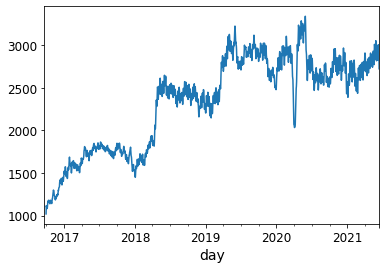

In [36]:
background_rate.rolling(10).mean().plot()

# Bring in neighborhood data (unused for now)

In [40]:
neighborhood = kml_to_gpd('Current_City_of_Detroit_Neighborhoods')
df = gpd.sjoin(neighborhood.loc[:,['nhood_name','geometry']], blight, how='left', op='intersects')

In [37]:
weapons = gpd.GeoDataFrame(pd.merge(
    calls.loc[calls.category.str.strip() == "WEAPON", :].groupby("neighborhood").agg(weapon_calls=('X','count')),
    neighborhood.loc[:, ["nhood_name","geometry"]],
    left_index=True,
    right_on="nhood_name",
))
weapons.head()

fig, ax = plt.subplots(1,1,figsize=(15,10))
weapons.plot('weapon_calls',ax=ax,cmap='Blues',legend=True)
ax.set(title='weapon 911 calls')

top_decile = weapons.weapon_calls.quantile(0.9)
for idx, row in weapons.iterrows():
#     plt.annotate(row.nhood_name,[x[0] for x in row.geometry.centroid.xy],fontsize=8)
    if row.weapon_calls > top_decile:
        pts = [x[0] for x in row.geometry.centroid.xy]
        plt.text(pts[0],pts[1],row.nhood_name, fontsize=8,horizontalalignment='center',bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

KeyboardInterrupt: 